This example shows how to use deep kernel learning (DKL) for classification. This is useful when you have very complex high-dimensional inputs (such as an image)

The example here is MNIST classification

For an introduction to DKL see these papers:
https://arxiv.org/abs/1511.02222
https://arxiv.org/abs/1611.00336

In [1]:
# Import our GPyTorch library
import gpytorch

# Import some classes we will use from torch
from torch.autograd import Variable
from torch.optim import SGD, Adam
from torch.utils.data import DataLoader

import torch
from torch import nn
from gpytorch.utils.lanczos_bidiagonalize import LanczosBidiagonalize, LanczosBidiagonalizeVariable

In [2]:
from dataloader import getDataloaders
config = {'augmentation': True}
train_loader, val_loader, test_loader = getDataloaders('cifar10', config)

loading cifar10
{'augmentation': True}
with data augmentation
dataset is normalized
Files already downloaded and verified


In [3]:
#from densenet import DenseNet
#model = DenseNet()
#state_dict = torch.load('pretrained_model_cifar10.model')
#model.load_state_dict(state_dict)
#from torchvision.models import vgg
#model = vgg.vgg19(pretrained=True).cuda()
from vgg import VGG
model = VGG()
state_dict = torch.load('checkpoint-200.pt')['state_dict']
model.load_state_dict(state_dict)

In [4]:
model = model.cuda()

In [5]:
model.features

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  

In [6]:
def get_activations_for_layer(input, model, layer):
    def hook(module, input, output):
        torch.save(output, 'tmp.pth')
    handle = layer.register_forward_hook(hook)
    model(input)
    handle.remove()
    activations = torch.load('tmp.pth')
    return activations

In [7]:
activations = get_activations_for_layer(Variable(train_loader.dataset[0][0].unsqueeze(0)).cuda(), model, model.features[20])
print(activations.shape, type(activations))

torch.Size([1, 512, 4, 4]) <class 'torch.autograd.variable.Variable'>


In [8]:
probe = activations.data

In [22]:
def conv_to_dense(conv_layer, probe_img, rank):
    # probe_img should be 1 x in_channels x imgw x imgh
    imgw = probe_img.size(-2)
    imgh = probe_img.size(-1)
    in_channels = conv_layer.in_channels
    out_channels = conv_layer.out_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    
    probe_vector = probe_img.view(in_channels * imgw * imgh)
    if conv_layer.bias is not None:
        new_conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
        new_conv_layer.load_state_dict(conv_layer.state_dict(), strict=False)
    else:
        new_conv_layer = conv_layer
    new_conv_layer_t = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
    new_conv_layer_t.load_state_dict(new_conv_layer.state_dict(), strict=False)
    
    matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, imgw, imgh)).cuda()).data.view(in_channels * imgw * imgh)
    matmul_t_closure = lambda v: new_conv_layer_t(Variable(v.contiguous().view(1, out_channels, imgw, imgh)).cuda()).data.view(in_channels * imgw * imgh)
    
    lb = LanczosBidiagonalize(max_iter=rank, cls=type(probe_vector))
    n_rows = out_channels * imgw * imgh
    n_cols = in_channels * imgw * imgh
    P, B, Q = lb.lanczos_bidiagonalize(matmul_closure, matmul_t_closure, probe_vector, n_rows, n_cols)
    return P, B, Q, new_conv_layer

In [26]:
def conv_to_dense_variable(conv_layer, probe_img, rank):
    # probe_img should be 1 x in_channels x imgw x imgh
    imgw = probe_img.size(-2)
    imgh = probe_img.size(-1)
    in_channels = conv_layer.in_channels
    out_channels = conv_layer.out_channels
    kernel_size = conv_layer.kernel_size
    stride = conv_layer.stride
    padding = conv_layer.padding
    
    probe_vector = probe_img.view(in_channels * imgw * imgh).contiguous()
    if conv_layer.bias is not None:
        new_conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
        new_conv_layer.load_state_dict(conv_layer.state_dict(), strict=False)
    else:
        new_conv_layer = conv_layer
    new_conv_layer_t = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
    new_conv_layer_t.load_state_dict(new_conv_layer.state_dict(), strict=False)
    
    matmul_closure = lambda v: new_conv_layer(v.contiguous().view(1, in_channels, imgw, imgh)).view(in_channels * imgw * imgh).contiguous()
    matmul_t_closure = lambda v: new_conv_layer_t(v.contiguous().view(1, out_channels, imgw, imgh)).view(in_channels * imgw * imgh).contiguous()
    
    lb = LanczosBidiagonalizeVariable(max_iter=rank, cls=type(probe_vector.data))
    n_rows = out_channels * imgw * imgh
    n_cols = in_channels * imgw * imgh
    P, B, Q = lb.lanczos_bidiagonalize(matmul_closure, matmul_t_closure, probe_vector, n_rows, n_cols)
    return P, B, Q, new_conv_layer

In [27]:
probe_img = Variable(probe.cuda())
P, B, Q, new_conv_layer = conv_to_dense_variable(model.features[21], probe_img, 20)
print(P.shape, Q.shape)

torch.Size([8192, 20]) torch.Size([8192, 20])


In [34]:
test_activations = get_activations_for_layer(Variable(train_loader.dataset[1][0].unsqueeze(0)).cuda(), model, model.features[20])
test_img = test_activations.data
in_channels = new_conv_layer.in_channels
out_channels = new_conv_layer.out_channels
imgw = test_img.size(-2)
imgh = test_img.size(-1)
left_mat = P.matmul(B)
my_out = left_mat.matmul(Q.t().matmul(Variable(test_img).squeeze().view(in_channels*imgw*imgh))).view(1, out_channels, imgw, imgh)
real_out = new_conv_layer(Variable(test_img).cuda()).data

In [39]:
my_out.sum(1).norm().backward()

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation

In [35]:
my_out[0, 0]

Variable containing:
1.00000e-02 *
  1.5437  2.7579 -1.7928  0.5235
  0.9395  1.5213 -4.9919  1.9294
  2.1203  5.4022 -0.6803  2.6550
 -3.7541 -2.0316 -4.1231 -1.7868
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [63]:
torch.sum(B.svd()[1] < 1e-3)

28

In [36]:
real_out[0, 0]


 0.1249  0.2007  0.0472  0.0329
-0.0805 -0.0843 -0.1621 -0.0317
-0.0863 -0.0923 -0.1104 -0.0130
-0.0646 -0.0629 -0.0717 -0.0261
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

## Define the feature extractor for our deep kernel

In [29]:
# probe_img should be 1 x in_channels x imgw x imgh
conv_layer = model.features[21]
rank = 100
imgw = probe_img.size(-2)
imgh = probe_img.size(-1)
in_channels = conv_layer.in_channels
out_channels = conv_layer.out_channels
kernel_size = conv_layer.kernel_size
stride = conv_layer.stride
padding = conv_layer.padding

probe_vector = torch.randn(in_channels * 8 * 8)

new_conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
new_conv_layer.load_state_dict(conv_layer.state_dict(), strict=False)
new_conv_layer_t = nn.ConvTranspose2d(out_channels, in_channels, kernel_size=kernel_size, padding=padding, stride=stride, bias=False).cuda()
new_conv_layer_t.load_state_dict(new_conv_layer.state_dict(), strict=False)

matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, imgw, imgh)).cuda()).data
matmul_t_closure = lambda v: new_conv_layer_t(Variable(v.contiguous().view(1, out_channels, imgw, imgh)).cuda()).data

lb = LanczosBidiagonalize(max_iter=rank, cls=type(probe_vector))
n_rows = out_channels * imgw * imgh
n_cols = in_channels * imgw * imgh

In [30]:
tmp_matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(16, in_channels, 4, 4))).data
tmp_single_matmul_closure = lambda v: new_conv_layer(Variable(v.contiguous().view(1, in_channels, 4, 4)).cuda()).data
full_matrix = torch.zeros(out_channels * 4 * 4, in_channels * 4 * 4)
#tmp_matmul_closure(torch.eye(32768))

In [34]:
imgw

4

In [35]:
query = torch.eye(in_channels * imgw * imgh)
for i in range(512):
    iquery = query[i*16:(i+1)*16, :]
    mv_result = tmp_matmul_closure(iquery.cuda()) # 16 x out_channels x 8 x 8
    full_matrix[:, i*16:(i+1)*16] = mv_result.view(16, out_channels * imgw * imgh).t()

In [36]:
v = torch.randn(in_channels * imgw * imgh)
foo = full_matrix.matmul(v).view(1, out_channels, imgw, imgh)
bar = tmp_single_matmul_closure(v)

In [37]:
foo[0, 0]


 0.0871  0.0523 -0.2962  0.1010
 0.1186 -0.1099 -0.2236  0.2003
 0.1621 -0.0005  0.1773 -0.0580
-0.1064 -0.0841 -0.0208 -0.0271
[torch.FloatTensor of size 4x4]

In [38]:
bar[0, 0]


 0.0871  0.0523 -0.2962  0.1010
 0.1186 -0.1099 -0.2236  0.2003
 0.1621 -0.0005  0.1773 -0.0580
-0.1064 -0.0841 -0.0208 -0.0271
[torch.cuda.FloatTensor of size 4x4 (GPU 0)]

In [39]:
full_matrix_gpu = full_matrix.cuda()

In [40]:
svs = full_matrix_gpu.svd()[1]

In [41]:
from matplotlib import pyplot as plt
%matplotlib inline

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:465: UserWarning: matplotlibrc text.usetex option can not be used unless TeX is installed on your system
  warnings.warn('matplotlibrc text.usetex option can not be used unless '
/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:473: UserWarning: matplotlibrc text.usetex can not be used with *Agg backend unless dvipng-1.6 or later is installed on your system
  'your system' % dvipng_req)


In [43]:
len(svs)

8192

Text(0,0.5,'singular value')

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


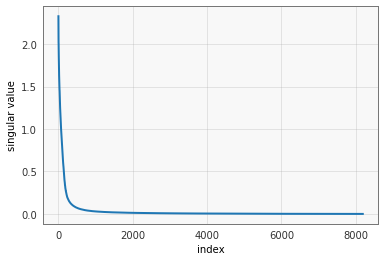

In [44]:
plt.plot(list(range(8192)), svs.cpu().numpy())
plt.xlabel('index')
plt.ylabel('singular value')

Text(0,0.5,'singular value')

/home/jrg365/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['Times'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


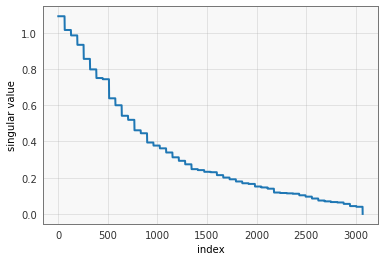

In [136]:
plt.plot(list(range(3072)), svs.cpu().numpy())
plt.xlabel('index')
plt.ylabel('singular value')